In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical

In [26]:
from mnist import MNIST
mndata = MNIST('./data')

In [27]:
train_x, train_y = mndata.load_training()
test_x, test_y = mndata.load_testing()

train_x = np.divide(train_x,255)
test_x = np.divide(test_x,255)

train_x = [np.reshape(train_img, (28,28,1)) for train_img in train_x]
test_x = [np.reshape(test_img, (28,28,1)) for test_img in test_x]

train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

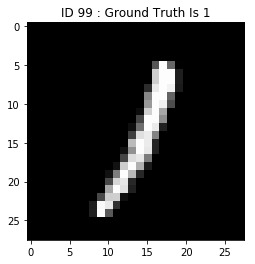

In [29]:
idx = 99

plt.title("ID " + str(idx) + " : Ground Truth Is " + str(np.argmax(train_y[idx])))
plt.imshow(train_x[idx][:,:,0], cmap="gray")

***
## <center> <br>Step 1
***
### <center> <br>Define TensorFlow Variables and Placeholders
***

- **Variables** are all the parameters that you want the training algorithm to determine for you
    - In our case, our <font color="orange">***weights***</font> and <font color="purple">***biases***</font>
<br><br>
- **Placeholders** are parameters that will be filled with actual data during training, typically training images
    - The shape of the tensor holding the training images is <font color="blue">***[None, 28, 28, 1]***</font> which stands for...
        - <font color="blue">***None***</font>      : This dimension will be the number of images in the mini-batch
            - Determined at training time
        - <font color="blue">***28, 28, 1***</font> : The images are 28x28 pixels x 1 value per pixel (grayscale)
            - The last number would be 3 for color images and is not really necessary here.

In [13]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])
W = tf.Variable(initial_value=tf.zeros([784, 10]))
b = tf.Variable(initial_value=tf.zeros([10]))

***
## <center> <br>Step 2
***
### <center> <br>Define The Model and Metrics
***

- We will be utilizing a softmax output (classification into one of many sets with a probability score)
    - To do this we will use tf.reshape to transform our 28x28 images into single vectors of 784 pixels
        - The "-1" in the reshape command means "computer, figure it out, there is only one possibility"
        - In practice it will be the number of images in a mini-batch.

    - We then need an additional placeholder for the training labels that will be provided alongside training images
<br><br>
- Now, we have model predictions and correct labels so we can compute the cross-entropy
    - tf.reduce_sum sums all the elements of a vector
<br><br>
- The last two lines compute the percentage of correctly recognised digits

In [14]:
# --------------------------------------------------------------------------------------------------------------
# model defined by Y = [X]*[w] + b
# Where X_ is a matrix of images that are vectors of length 784
# Where W is a matrix of weights
# Where b is a constant known as the bias
# --------------------------------------------------------------------------------------------------------------
Y = tf.nn.softmax(tf.matmul(tf.reshape(X, [-1, 784]), W) + b)
# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------
# Y_ is a placeholder for correct labels
# Its has the shape [None, 10] as... 
#     - It will be in a batch of unknown size (defined at runtime)
#     - It is a one-hot-encoded vector of length 10
#            -- i.e. The digit three (3)  --->  would be one-hot-encoded as  --->   [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# --------------------------------------------------------------------------------------------------------------
Y_ = tf.placeholder(tf.float32, [None, 10])
# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------
# Loss Function -- Cross Entropy
# Now, we have model predictions and correct labels so we can compute the cross-entropy (how badly/good did we do?)
#     - tf.reduce_sum sums all the elements of a vector
#     - cross entropy is the sum of all of the products of the guesses multiplied by the ground truth values (negative)
# --------------------------------------------------------------------------------------------------------------
# logits are probabilities
cross_entropy = -tf.reduce_mean(Y_*tf.log(Y))*1000
# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------
# Percentage of Correct Answers Found in Batch
# is_correct will contain an array of binary values
#      - These values correspond to whether or not the predicted value equals the ground truth value
# accuracy is a float that is generated by calculating the mean of the is_correct array
#      - i.e. if is_correct = [0, 1, 1, 1, 1, 1] ... the mean is (0+1+1+1+1+1)/(6) = 0.83333 ... or 83.33%
#           -- NOTE: tf.cast simply creates a new tensor by changing the datatype from the current to the desired
# --------------------------------------------------------------------------------------------------------------
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
# --------------------------------------------------------------------------------------------------------------
#
# --------------------------------------------------------------------------------------------------------------
train_accuracy_tb = tf.summary.scalar(name='train_accuracy', tensor=accuracy)
train_loss_tb = tf.summary.scalar(name='train_loss', tensor=cross_entropy)
test_accuracy_tb = tf.summary.scalar(name='test_accuracy', tensor=accuracy)
test_loss_tb = tf.summary.scalar(name='test_loss', tensor=cross_entropy)
# --------------------------------------------------------------------------------------------------------------

***
## <center> <br>Step 3
***
### <center> <br>Define The Optimizer and One Training Step
***

- This where the TensorFlow magic happens
<br><br>
- You select an optimizer (there are many available) and ask it to minimise the cross-entropy loss
    - In this step, TensorFlow computes the partial derivatives of the loss function relatively to all the weights and all the biases (the gradient)
    - This is a formal derivation, not a numerical one which would be far too time-consuming
<br><br>
- The gradient is then used to update the weights and biases
    - NOTE: 0.003 is the learning rate (alpha)

In [15]:
# This optimizer (gradientdescentoptimizer) is not ideal and will yield slightly worse results
#optimizer = tf.train.GradientDescentOptimizer(0.003)
optimizer = tf.train.AdamOptimizer(learning_rate=0.003, epsilon=1e-08)
train_step = optimizer.minimize(cross_entropy)

***
## <center> <br>Step 4
***
### <center> <br>Run The Training Loop (Session Time!)
***

- All the TensorFlow instructions up to this point have been preparing a computation graph in memory but nothing has been computed yet
<br><br>
- TensorFlow's "deferred execution" model: 
    - TensorFlow was built for distributed computing
    - It has to know what you are going to compute, the execution graph, before it starts actually sending compute tasks to various computers/cores 
    - You first use TensorFlow functions to create a computation graph in memory, then start an execution Session and perform actual computations using Session.run
        - At this point the graph cannot be changed anymore.
    - Thanks to this model, TensorFlow can take over a lot of the logistics of distributed computing
        - For example, if your instruct it to run one part of the computation on computer 1 and another part on computer 2, it can make the necessary data transfers happen automatically
<br><br>
- The computation requires actual data to be fed into the placeholders you have previously defined in your TensorFlow code
    - This is supplied in the form of a Python dictionary where the keys are the names of the placeholders

In [16]:
BATCH_SIZE = 100
NUMBER_OF_BATCHES = int(len(train_x)/BATCH_SIZE)

EPOCHS = 10

test_data={X: np.reshape(test_x,(-1,28,28,1)), Y_: np.reshape(test_y,(-1,10))}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./graphs', sess.graph)

    for j in range(EPOCHS):
        print("\n---------------------------\nEPOCH {} of {}\n---------------------------".format(j, EPOCHS))
        for i in range(NUMBER_OF_BATCHES):
            
            # load batch of images and correct answers
            batch_X = np.reshape(train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE], (-1, 28, 28, 1))
            batch_Y = np.reshape(train_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE], (-1, 10))

            train_data={X: batch_X, Y_: batch_Y}

            # train
            sess.run(train_step, feed_dict=train_data)
            
            tb_1, tb_2 = sess.run([train_accuracy_tb, train_loss_tb], feed_dict=train_data)
            tb_3, tb_4 = sess.run([test_accuracy_tb, test_loss_tb], feed_dict=test_data)
            
            if i%10==0:
                print("\n---------------------------\nBATCH {} of {}\n---------------------------".format(i, NUMBER_OF_BATCHES))
                a,c= sess.run([accuracy, cross_entropy], feed_dict=train_data)
        
                # Step 9 - Add the Summary to the Writer (i.e. to the event file) at a given iteration number
                writer.add_summary(tb_1, ((i+1)*(j+1)))
                writer.add_summary(tb_2, ((i+1)*(j+1)))
                writer.add_summary(tb_3, ((i+1)*(j+1)))
                writer.add_summary(tb_4, ((i+1)*(j+1)))
                
                print("\nTrain -- Accuracy : {}\nTrain -- Cross Entropy: {}\n".format(a,c))
                if i%100==0:
                    
                    a,c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
                    print("\nTest -- Accuracy : {}\nTest -- Cross Entropy: {}\n".format(a,c))
                    
        writer.close()


---------------------------
EPOCH 0 of 10
---------------------------

---------------------------
BATCH 0 of 600
---------------------------

Train -- Accuracy : 0.6600000262260437
Train -- Cross Entropy: 210.4862060546875


Test -- Accuracy : 0.3617999851703644
Test -- Cross Entropy: 219.11895751953125


---------------------------
BATCH 10 of 600
---------------------------

Train -- Accuracy : 0.6899999976158142
Train -- Cross Entropy: 145.84146118164062


---------------------------
BATCH 20 of 600
---------------------------

Train -- Accuracy : 0.7699999809265137
Train -- Cross Entropy: 94.30139923095703


---------------------------
BATCH 30 of 600
---------------------------

Train -- Accuracy : 0.7799999713897705
Train -- Cross Entropy: 90.80301666259766


---------------------------
BATCH 40 of 600
---------------------------

Train -- Accuracy : 0.8700000047683716
Train -- Cross Entropy: 63.09272384643555


---------------------------
BATCH 50 of 600
----------------------


---------------------------
BATCH 500 of 600
---------------------------

Train -- Accuracy : 0.8899999856948853
Train -- Cross Entropy: 35.15254592895508


Test -- Accuracy : 0.916100025177002
Test -- Cross Entropy: 30.47196388244629


---------------------------
BATCH 510 of 600
---------------------------

Train -- Accuracy : 0.9399999976158142
Train -- Cross Entropy: 19.77799415588379


---------------------------
BATCH 520 of 600
---------------------------

Train -- Accuracy : 0.8700000047683716
Train -- Cross Entropy: 38.39900207519531


---------------------------
BATCH 530 of 600
---------------------------

Train -- Accuracy : 0.8700000047683716
Train -- Cross Entropy: 32.916465759277344


---------------------------
BATCH 540 of 600
---------------------------

Train -- Accuracy : 0.8700000047683716
Train -- Cross Entropy: 39.98031234741211


---------------------------
BATCH 550 of 600
---------------------------

Train -- Accuracy : 0.9100000262260437
Train -- Cross Entro


---------------------------
BATCH 400 of 600
---------------------------

Train -- Accuracy : 0.9399999976158142
Train -- Cross Entropy: 25.70122528076172


Test -- Accuracy : 0.9189000129699707
Test -- Cross Entropy: 28.93045425415039


---------------------------
BATCH 410 of 600
---------------------------

Train -- Accuracy : 0.9100000262260437
Train -- Cross Entropy: 34.64419174194336


---------------------------
BATCH 420 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entropy: 30.684146881103516


---------------------------
BATCH 430 of 600
---------------------------

Train -- Accuracy : 0.8700000047683716
Train -- Cross Entropy: 31.87921714782715


---------------------------
BATCH 440 of 600
---------------------------

Train -- Accuracy : 0.9700000286102295
Train -- Cross Entropy: 15.773460388183594


---------------------------
BATCH 450 of 600
---------------------------

Train -- Accuracy : 0.8899999856948853
Train -- Cross Ent


---------------------------
BATCH 300 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entropy: 26.743410110473633


Test -- Accuracy : 0.9204000234603882
Test -- Cross Entropy: 27.955541610717773


---------------------------
BATCH 310 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entropy: 31.3740177154541


---------------------------
BATCH 320 of 600
---------------------------

Train -- Accuracy : 0.8899999856948853
Train -- Cross Entropy: 28.582765579223633


---------------------------
BATCH 330 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entropy: 23.422283172607422


---------------------------
BATCH 340 of 600
---------------------------

Train -- Accuracy : 0.9399999976158142
Train -- Cross Entropy: 24.594532012939453


---------------------------
BATCH 350 of 600
---------------------------

Train -- Accuracy : 0.949999988079071
Train -- Cross En


---------------------------
BATCH 190 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 26.22629165649414


---------------------------
BATCH 200 of 600
---------------------------

Train -- Accuracy : 0.8899999856948853
Train -- Cross Entropy: 28.3431453704834


Test -- Accuracy : 0.9258999824523926
Test -- Cross Entropy: 26.93388557434082


---------------------------
BATCH 210 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entropy: 34.64323043823242


---------------------------
BATCH 220 of 600
---------------------------

Train -- Accuracy : 0.9700000286102295
Train -- Cross Entropy: 11.150911331176758


---------------------------
BATCH 230 of 600
---------------------------

Train -- Accuracy : 0.8999999761581421
Train -- Cross Entropy: 41.047149658203125


---------------------------
BATCH 240 of 600
---------------------------

Train -- Accuracy : 0.9399999976158142
Train -- Cross Entr


---------------------------
BATCH 90 of 600
---------------------------

Train -- Accuracy : 0.9599999785423279
Train -- Cross Entropy: 17.808046340942383


---------------------------
BATCH 100 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 26.94265365600586


Test -- Accuracy : 0.925599992275238
Test -- Cross Entropy: 27.255393981933594


---------------------------
BATCH 110 of 600
---------------------------

Train -- Accuracy : 0.9399999976158142
Train -- Cross Entropy: 16.274505615234375


---------------------------
BATCH 120 of 600
---------------------------

Train -- Accuracy : 0.9100000262260437
Train -- Cross Entropy: 25.50939178466797


---------------------------
BATCH 130 of 600
---------------------------

Train -- Accuracy : 0.8399999737739563
Train -- Cross Entropy: 53.845489501953125


---------------------------
BATCH 140 of 600
---------------------------

Train -- Accuracy : 0.8799999952316284
Train -- Cross Ent


---------------------------
BATCH 590 of 600
---------------------------

Train -- Accuracy : 1.0
Train -- Cross Entropy: 5.486687660217285


---------------------------
EPOCH 5 of 10
---------------------------

---------------------------
BATCH 0 of 600
---------------------------

Train -- Accuracy : 0.9599999785423279
Train -- Cross Entropy: 18.989299774169922


Test -- Accuracy : 0.9222999811172485
Test -- Cross Entropy: 27.437612533569336


---------------------------
BATCH 10 of 600
---------------------------

Train -- Accuracy : 0.8700000047683716
Train -- Cross Entropy: 50.56488037109375


---------------------------
BATCH 20 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 25.530200958251953


---------------------------
BATCH 30 of 600
---------------------------

Train -- Accuracy : 0.9100000262260437
Train -- Cross Entropy: 31.616281509399414


---------------------------
BATCH 40 of 600
---------------------------

Train


---------------------------
BATCH 490 of 600
---------------------------

Train -- Accuracy : 0.8899999856948853
Train -- Cross Entropy: 46.567447662353516


---------------------------
BATCH 500 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entropy: 28.2723388671875


Test -- Accuracy : 0.925599992275238
Test -- Cross Entropy: 26.89126205444336


---------------------------
BATCH 510 of 600
---------------------------

Train -- Accuracy : 0.9599999785423279
Train -- Cross Entropy: 15.028081893920898


---------------------------
BATCH 520 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 24.50718879699707


---------------------------
BATCH 530 of 600
---------------------------

Train -- Accuracy : 0.8799999952316284
Train -- Cross Entropy: 26.460798263549805


---------------------------
BATCH 540 of 600
---------------------------

Train -- Accuracy : 0.8899999856948853
Train -- Cross Entr


---------------------------
BATCH 390 of 600
---------------------------

Train -- Accuracy : 0.9700000286102295
Train -- Cross Entropy: 16.350841522216797


---------------------------
BATCH 400 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entropy: 23.637649536132812


Test -- Accuracy : 0.9254000186920166
Test -- Cross Entropy: 27.692646026611328


---------------------------
BATCH 410 of 600
---------------------------

Train -- Accuracy : 0.9100000262260437
Train -- Cross Entropy: 35.10620880126953


---------------------------
BATCH 420 of 600
---------------------------

Train -- Accuracy : 0.9399999976158142
Train -- Cross Entropy: 27.60845184326172


---------------------------
BATCH 430 of 600
---------------------------

Train -- Accuracy : 0.9100000262260437
Train -- Cross Entropy: 26.334957122802734


---------------------------
BATCH 440 of 600
---------------------------

Train -- Accuracy : 0.9700000286102295
Train -- Cross E


---------------------------
BATCH 290 of 600
---------------------------

Train -- Accuracy : 0.949999988079071
Train -- Cross Entropy: 18.404550552368164


---------------------------
BATCH 300 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entropy: 24.356447219848633


Test -- Accuracy : 0.9247999787330627
Test -- Cross Entropy: 27.31103515625


---------------------------
BATCH 310 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 30.20946502685547


---------------------------
BATCH 320 of 600
---------------------------

Train -- Accuracy : 0.9100000262260437
Train -- Cross Entropy: 25.560199737548828


---------------------------
BATCH 330 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 21.551380157470703


---------------------------
BATCH 340 of 600
---------------------------

Train -- Accuracy : 0.9200000166893005
Train -- Cross Entro


---------------------------
BATCH 190 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 23.677438735961914


---------------------------
BATCH 200 of 600
---------------------------

Train -- Accuracy : 0.9100000262260437
Train -- Cross Entropy: 24.96122932434082


Test -- Accuracy : 0.9258999824523926
Test -- Cross Entropy: 26.803319931030273


---------------------------
BATCH 210 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 31.712024688720703


---------------------------
BATCH 220 of 600
---------------------------

Train -- Accuracy : 0.9700000286102295
Train -- Cross Entropy: 10.5400390625


---------------------------
BATCH 230 of 600
---------------------------

Train -- Accuracy : 0.8999999761581421
Train -- Cross Entropy: 40.31002426147461


---------------------------
BATCH 240 of 600
---------------------------

Train -- Accuracy : 0.949999988079071
Train -- Cross Entropy


---------------------------
BATCH 90 of 600
---------------------------

Train -- Accuracy : 0.9599999785423279
Train -- Cross Entropy: 16.723548889160156


---------------------------
BATCH 100 of 600
---------------------------

Train -- Accuracy : 0.9399999976158142
Train -- Cross Entropy: 26.066007614135742


Test -- Accuracy : 0.9251999855041504
Test -- Cross Entropy: 27.260818481445312


---------------------------
BATCH 110 of 600
---------------------------

Train -- Accuracy : 0.9599999785423279
Train -- Cross Entropy: 15.10089111328125


---------------------------
BATCH 120 of 600
---------------------------

Train -- Accuracy : 0.9300000071525574
Train -- Cross Entropy: 23.834617614746094


---------------------------
BATCH 130 of 600
---------------------------

Train -- Accuracy : 0.8399999737739563
Train -- Cross Entropy: 50.65113830566406


---------------------------
BATCH 140 of 600
---------------------------

Train -- Accuracy : 0.8899999856948853
Train -- Cross En


---------------------------
BATCH 590 of 600
---------------------------

Train -- Accuracy : 1.0
Train -- Cross Entropy: 4.81904411315918

